In [1]:
import re, time, warnings, os, sys, copy
import gzip, pickle

import numpy as np
import pandas as pd
import gzip, pickle
import scipy, sklearn, mne

import auxiliary as aux
import data, rsa
sys.path.append('../../spaces/')
import embeddings as emb
import pubplot as pub
import matplotlib.pyplot as plt

pub.styles.set()
C = pub.colours.equidistant('tab20c', k = 20)

## Supplementary Figures 3-5, Supplementary Tables 4-5
This notebook generates supplementary results for top-k encoding analysis as well as cRSM correlations.

In [2]:
k = np.arange(1, 20, 2)

with gzip.open(f'./data/results/encoding_topk_b0-m0-c0.pkl.gz', 'rb') as f:
    r, ß, onesamp, contrasts = pickle.load(f)

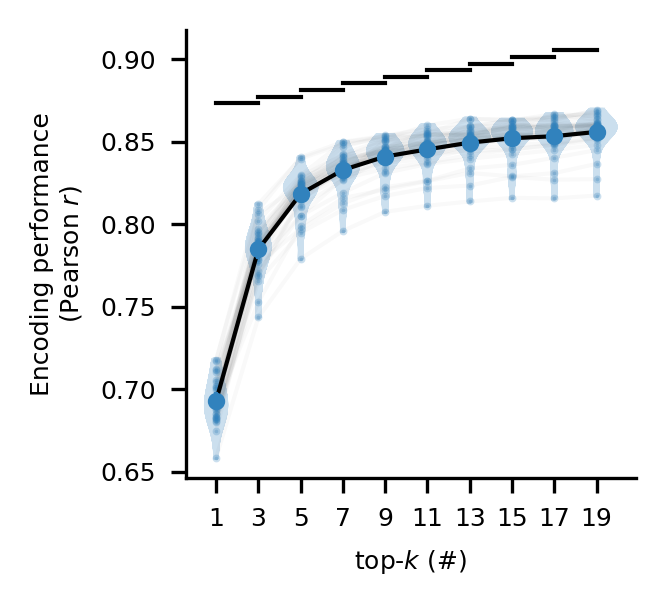

In [3]:
'''
Generate figure 3
'''

enc = r.squeeze().T

fig, ax = pub.figure(nrows = 1, ncols = 1)
pub.dist.violins(enc, colours = [C[0]] * len(k), ax = ax)

ax.set_ylabel('Encoding performance\n' + r'(Pearson $r$)')
ax.set_xlabel(r'top-$k$ (#)')
ax.set_xticks(np.arange(len(k)), labels = k)

absmax = enc.max()
sigs = 1
diff = 0.004

for key in contrasts:
    contrast = contrasts[key]
    
    i, j = key.split('-')
    i, j = int(i), int(j)
    
    p = contrast['p_cor']
    
    if p <= .05:
        ax.plot([i, j], [absmax + sigs * diff, absmax + sigs * diff], color = 'black')
        sigs += 1
    
pub.cosmetics.finish()

fig.savefig(f'./figures/png/suppfig3_topk.png', dpi = 300)
fig.savefig(f'./figures/svg/suppfig3_topk.svg')
fig.savefig(f'./figures/pdf/suppfig3_topk.pdf')

dpi = 300  # any value; inches = pixels / dpi

fig.savefig(
    f'./figures/tiff/suppfig3_topk.tiff',
    dpi=dpi,
    format="tiff",
    # needs Matplotlib >=3.7 for pil_kwargs
    pil_kwargs={"compression": "tiff_lzw"}  # or "tiff_adobe_deflate", "raw"
)

In [4]:
'''
Generate table 4
'''

contrast = []
mu = []
sd = []
t = []
df = []
p = []
d = []

for key in contrasts:
    i, j = key.split('-')
    i, j = int(i), int(j)
    con = contrasts[key]
    
    contrast.append(f'{k[i]}-{k[j]}')
    mu.append(np.round(con['mu'], 3))
    sd.append(np.round(con['sd'], 3))
    t.append(np.round(con['t'], 3))
    df.append(con['df'])
    p.append(con['p_cor'])
    d.append(con['d'])

df = {'contrast': contrast, 'M': mu, 'Std. Dev': sd, 'df': df, 't-value': t, 'p-value': p}
df = pd.DataFrame.from_dict(df)
print(df.to_latex(index = False))

\begin{tabular}{lrrrrr}
\toprule
contrast &     M &  Std. Dev &  df &  t-value &      p-value \\
\midrule
     3-1 & 0.092 &     0.011 &  34 &   49.284 & 2.954380e-32 \\
     5-3 & 0.034 &     0.007 &  34 &   27.689 & 5.264768e-24 \\
     7-5 & 0.014 &     0.003 &  34 &   24.428 & 2.674880e-22 \\
     9-7 & 0.008 &     0.004 &  34 &   13.033 & 5.308751e-14 \\
    11-9 & 0.004 &     0.003 &  34 &    9.122 & 5.810556e-10 \\
   13-11 & 0.004 &     0.003 &  34 &    8.287 & 4.540814e-09 \\
   15-13 & 0.003 &     0.002 &  34 &    7.560 & 2.655277e-08 \\
   17-15 & 0.001 &     0.002 &  34 &    3.150 & 3.398163e-03 \\
   19-17 & 0.003 &     0.002 &  34 &    6.885 & 1.250519e-07 \\
\bottomrule
\end{tabular}



/var/folders/b4/qysvl6jd4995kp_qql3yj3880000gn/T/ipykernel_71171/449113513.py:28: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index = False))


In [5]:
with gzip.open(f'./data/results/encoding_b0-m0-c0-k19.pkl.gz', 'rb') as f:
    (r_a, ß_a, r_s, ß_s, r_as, ß_as, one_samp, contrasts, cluster_based) = pickle.load(f)

import matplotlib
C1 = pub.colours.equidistant('YlOrRd', k = 20)
cols_inv = [C1[5], C1[12], C1[10]]
cols_spc = [C1[7], C1[13], C1[11]]
cols_bot = [C1[9], C1[14], C1[12]]

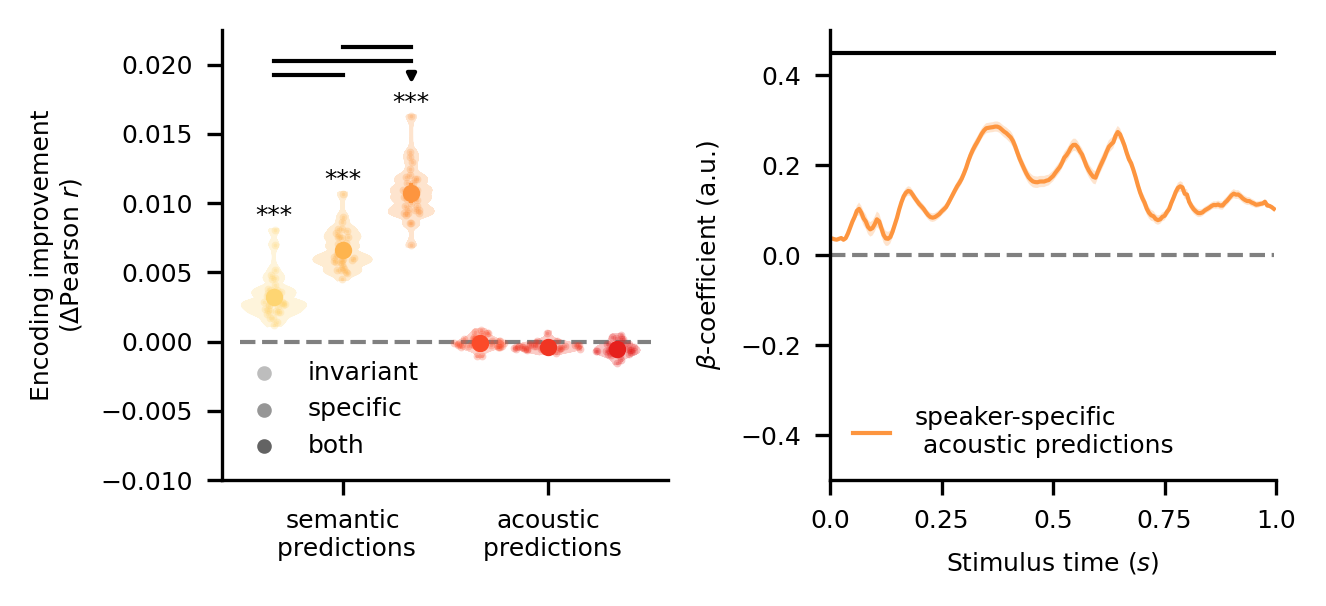

In [6]:
'''
Generate figure 4
'''

fig, ax = pub.figure(nrows = 1, ncols = 2)

d_a = r_a[:,1:] - r_a[:,0,None]
d_s = r_s[:,1:] - r_s[:,0,None]

bw = np.array([d_a, d_s]).flatten()
bw = pub.dist._bandwidth_botev(bw)
vmax = np.abs(np.array([d_a, d_s])).max()

ax[0].plot([-0.5, 5.5], [0, 0], color = 'gray', linestyle = '--')
pub.dist.violins(d_a.T, scatter_dep = False, colours = [cols_inv[0], cols_spc[0], cols_bot[0]], jitter = True, jitter_max = 1.75 * bw, kernel_bandwidth = bw, ax = ax[0])
pub.dist.violins(d_s.T, scatter_dep = False, colours = [cols_inv[1], cols_spc[1], cols_bot[1]], jitter = True, jitter_max = 1.75 * bw, offset_x = 3, kernel_bandwidth = bw, ax = ax[0])

ax[0].scatter([-1], [-1], color = C[18], marker = '.', s = 25, label = 'invariant')
ax[0].scatter([-1], [-1], color = C[17], marker = '.', s = 25, label = 'specific')
ax[0].scatter([-1], [-1], color = C[16], marker = '.', s = 25, label = 'both')

# add significance
sigs = 3
sigs_a = 3
sigs_s = 3
sigs_as = 3
off = 0.001

for k in contrasts:
    # get descriptives
    T, v = k.split(':')
    if T not in ['a', 's', 'as']: v0 = v1 = int(v[1:])
    else: v0, v1 = v[1:].split('-')
    v0, v1 = int(v0), int(v1)
    
    # skip if not required
    if T not in ['a', 's', 's-a']: continue
    
    # get contrast
    contrast = contrasts[k]
    pv = contrast['p_cor']
    
    if pv <= .05:
        lab = pub.significance.__sig_from_p(pv)
        i, j = v0, v1
        
        if T == 'a':
            i, j = v0, v1
                        
            if v1 == 0:
                xy = (i-1, d_a[:,i-1].max() + off)
                ax[0].annotate(lab, xy = xy, xytext = xy, ha = 'center', va = 'center')
                continue
            
            sigs = sigs_a
            sigs_a += 1
        elif T == 's':
            continue
            
            i, j = v0, v1
            
            if v1 == 0:
                xy = (i+2, d_s[:,i-1].max() + off)
                ax[0].annotate(lab, xy = xy, xytext = xy, ha = 'center', va = 'center')
                continue
            
            i, j = i + 3, j + 3
            sigs = sigs_s
            sigs_s += 1
            
        elif T == 's-a':
            continue
            
            i, j = v0, v1 + 3
            
            sigs_as = np.array([sigs_a, sigs_s, sigs_as]).max()
            sigs = sigs_as
            sigs_as += 1
        
        ax[0].plot([i-1, j-1], [vmax + sigs * off, vmax + sigs * off], color = 'black')
        sigs += 1

all_m = np.concatenate((d_a, d_s), axis = 1)
best = all_m.mean(axis = 0).argmax()
ax[0].scatter([best], all_m[:,best].max() + 3 * off, marker = 'v', s = 3, color = 'black')

ax[0].set_ylim([-0.01, 0.0225])
ax[0].set_xlim([-0.75, 5.75])
ax[0].set_xticks([1, 4], labels = ['semantic\n predictions', 'acoustic\n predictions'])
ax[0].set_ylabel('Encoding improvement\n' + r'($\Delta$Pearson $r$)')
pub.cosmetics.legend(ax = ax[0], loc = 'lower left')

ß = ß_a[:,3,4,:]
mu = ß.mean(axis = 0)
se = rsa.stats.bootstrap_se(ß)
t = np.arange(se.shape[0])
cluster = cluster_based['a']['m3']['ß4'][0]

ax[1].plot(t*0, color = 'gray', linestyle = '--')
ax[1].fill_between(t, mu - 1.96 * se, mu + 1.96 * se, edgecolor = None, facecolor = cols_bot[0], alpha = 0.25)
ax[1].plot(mu, color = cols_bot[0], label = 'speaker-specific\n acoustic predictions')

if cluster['p_cor'] <= 0.05:
    tmin, tmax = cluster['tmin'], cluster['tmax']
    ax[1].plot([tmin, tmax], [0.45, 0.45], color = 'black')

ax[1].set_ylim([-0.5, 0.5])
ax[1].set_xlim([0, 200])
ax[1].set_xticks(np.arange(0, 201, 50))
ax[1].set_xticklabels(np.round(np.arange(0, 201, 50)*5e-3, 2))
ax[1].set_ylabel(r'$\beta$-coefficient (a.u.)')
ax[1].set_xlabel(r'Stimulus time ($s$)')
pub.cosmetics.legend(ax = ax[1], loc = 'lower left')

pub.cosmetics.finish()

fig.savefig(f'./figures/png/suppfig4_k19.png', dpi = 300)
fig.savefig(f'./figures/svg/suppfig4_k19.svg')
fig.savefig(f'./figures/pdf/suppfig4_k19.pdf')

dpi = 300  # any value; inches = pixels / dpi

fig.savefig(
    f'./figures/tiff/suppfig4_k19.tiff',
    dpi=dpi,
    format="tiff",
    # needs Matplotlib >=3.7 for pil_kwargs
    pil_kwargs={"compression": "tiff_lzw"}  # or "tiff_adobe_deflate", "raw"
)

In [7]:
'''
Generate table 5
'''

contrast = []
mu = []
sd = []
t = []
df = []
p = []
d = []

for key in contrasts:
    
    x = key.split(':')
    if len(x[0].split('-')) > 1:
        t0, t1 = x[0].split('-')
        p0, p1 = x[1], x[1]
        p0, p1 = p0[1:], p1[1:]
    else:
        t0, t1 = x[0], x[0]
        p0, p1 = x[1].split('-')
        p0 = p0[1:]
    
    if 'as' in [t0, t1]: continue
    if (p0 == '0') & (p1 == '0'): continue
    
    i, j = int(p0), int(p1)
    
    ts = {'a': 'ac.', 's': 'sem.'}
    t0, t1 = ts[t0], ts[t1]
    
    ps = ['baseline', 'inv.', 'spc.', 'bth.']
    p0, p1 = ps[i], ps[j]
    
    name = f'{t0}{p0}-{t1}{p1}' if p1 != 'baseline' else f'{t0}{p0}-baseline'
    con = contrasts[key]
    
    contrast.append(name)
    mu.append(np.round(con['mu'], 4))
    sd.append(np.round(con['sd'], 4))
    t.append(np.round(con['t'], 4))
    df.append(con['df'])
    p.append(con['p_cor'])
    d.append(con['d'])

df = {'contrast': contrast, 'M': mu, 'Std. Dev': sd, 'df': df, 't-value': t, 'p-value': p}
df = pd.DataFrame.from_dict(df)
print(df.to_latex(index = False))

\begin{tabular}{lrrrrr}
\toprule
         contrast &       M &  Std. Dev &  df &  t-value &      p-value \\
\midrule
 ac.inv.-baseline &  0.0032 &    0.0014 &  34 &  13.1557 & 1.083377e-13 \\
 ac.spc.-baseline &  0.0066 &    0.0013 &  34 &  29.3987 & 2.415507e-24 \\
  ac.spc.-ac.inv. &  0.0034 &    0.0014 &  34 &  14.1754 & 1.331002e-14 \\
 ac.bth.-baseline &  0.0107 &    0.0017 &  34 &  36.9431 & 1.487629e-27 \\
  ac.bth.-ac.inv. &  0.0075 &    0.0015 &  34 &  29.7752 & 1.714360e-24 \\
  ac.bth.-ac.spc. &  0.0041 &    0.0011 &  34 &  20.7433 & 1.481206e-19 \\
sem.inv.-baseline & -0.0001 &    0.0004 &  34 &  -0.8850 & 1.000000e+00 \\
sem.spc.-baseline & -0.0004 &    0.0002 &  34 &  -8.3291 & 1.312180e-08 \\
sem.spc.-sem.inv. & -0.0003 &    0.0004 &  34 &  -4.4158 & 8.721333e-04 \\
sem.bth.-baseline & -0.0005 &    0.0004 &  34 &  -6.8839 & 7.533303e-07 \\
sem.bth.-sem.inv. & -0.0005 &    0.0001 &  34 & -22.5252 & 1.133089e-20 \\
sem.bth.-sem.spc. & -0.0002 &    0.0004 &  34 &  -2.5786 &

/var/folders/b4/qysvl6jd4995kp_qql3yj3880000gn/T/ipykernel_71171/842862142.py:49: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index = False))


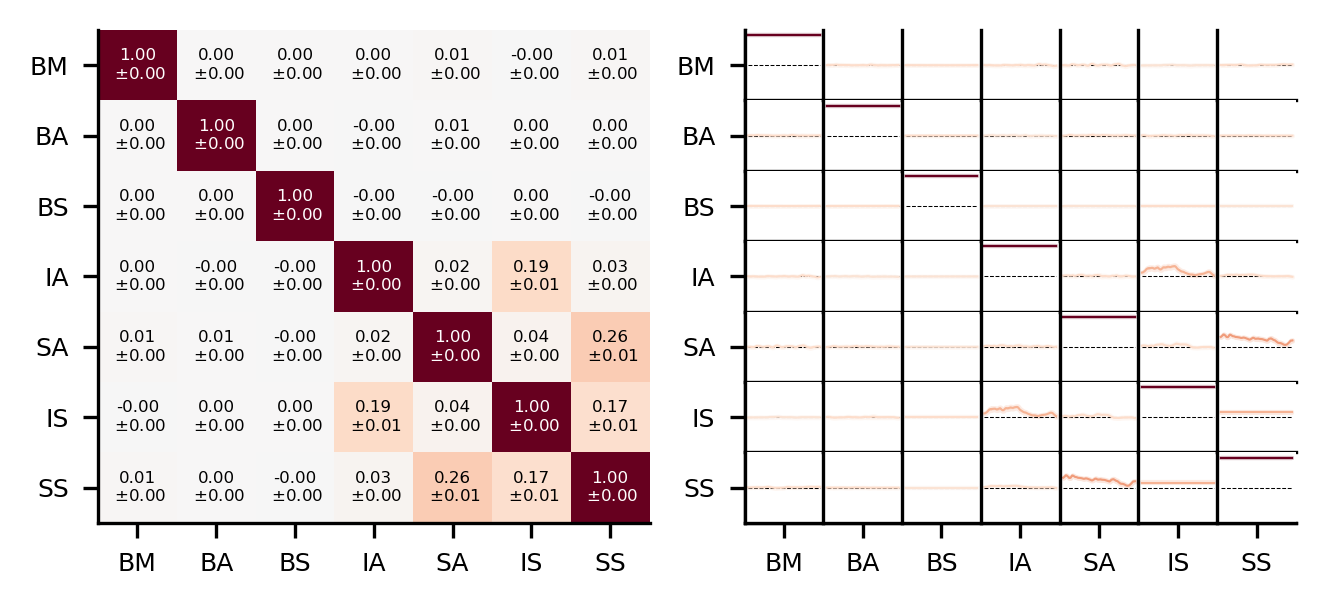

In [9]:
'''
Generate figure 5
'''

with gzip.open(f'./data/processed/misc/rdm_corrs.pkl.gz', 'rb') as f:
    rdms = pickle.load(f)

import seaborn as sns

fig, ax = pub.figure(nrows = 1, ncols = 2)

names = ['BM', 'BA', 'BS', 'IA', 'SA', 'IS', 'SS']

ax[0].imshow(rdms.mean(0).mean(-1), vmin = -1, vmax = 1.0, aspect = 'auto', cmap = 'RdBu_r')
for i in range(rdms.shape[1]):
    for j in range(rdms.shape[2]):
        mu = rdms[:,i,j,:].mean()
        se = rdms[:,i,j,:].mean(-1)
        se = se[np.random.choice(np.arange(se.shape[0]), replace = True, size = (1000, se.shape[0]))].mean(-1).std(0)
        annotation = f'{mu:.2f}\n'
        annotation += r' $\pm$'
        annotation += f'{se:.2f}'
        col_i = 'white' if i == j else 'black'
        
        ax[0].annotate(annotation, xy = (0, 0), xytext = (i, j), ha = 'center', va = 'center', fontsize = 4, color = col_i)

ax[0].set_xticks(np.arange(rdms.shape[1]), names)
ax[0].set_yticks(np.arange(rdms.shape[1]), names)

cols_c = 5
cols_k = 50
cols = pub.colours.equidistant('RdBu_r', k = cols_k)

ax[1].set_xlim([0, 1])
ax[1].set_ylim([0, 1])

for i in range(rdms.shape[1]):
    for j in range(rdms.shape[1]):
        x, y = i, j
        
        mu_i = rdms[:,i,j,:].mean(0)
        se_i = rdms[:,i,j,:][np.random.choice(np.arange(rdms.shape[0]), replace = True, size = (1000, rdms.shape[0]))].mean(1).std(0)
        t_i = np.arange(mu_i.shape[0])
        
        x_i = x / rdms.shape[1]
        y_i = 1 - (y + 1) / rdms.shape[1]
        col_i = cols[min(max(int((mu_i.mean() + 1.0) / 2.0 * cols_k) - 1, 0) + cols_c, len(cols) - 1)]
        
        ax_ij = ax[1].inset_axes([x_i, y_i, 1 / rdms.shape[1], 1 / rdms.shape[1]])
        ax_ij.set_xticks([])
        ax_ij.set_yticks([])
        ax_ij.set_ylim([-1.175, 1.175])
        ax_ij.plot(0*mu_i, color = 'black', linewidth = 0.25, linestyle = '--')
        ax_ij.plot(mu_i, color = col_i, linewidth = 0.5)
        ax_ij.fill_between(t_i, mu_i - 1.96 * se_i, mu_i + 1.96 * se_i, color = col_i, alpha = 0.25)
        sns.despine(ax = ax_ij)

ax[1].set_xticks((np.arange(rdms.shape[1]) + 0.5) / rdms.shape[1], names)
ax[1].set_yticks((np.arange(rdms.shape[1]) + 0.5)[::-1] / rdms.shape[1], names)

pub.cosmetics.finish()

fig.savefig(f'./figures/png/suppfig5_corrs.png', dpi = 300)
fig.savefig(f'./figures/svg/suppfig5_corrs.svg')
fig.savefig(f'./figures/pdf/suppfig5_corrs.pdf')

dpi = 300  # any value; inches = pixels / dpi

fig.savefig(
    f'./figures/tiff/suppfig5_corrs.tiff',
    dpi=dpi,
    format="tiff",
    # needs Matplotlib >=3.7 for pil_kwargs
    pil_kwargs={"compression": "tiff_lzw"}  # or "tiff_adobe_deflate", "raw"
)